# Depth Mapping from Normal Mapping with Averaged Integrals from Rotated Discrete Origin Functions

This algorithm estimates a 3d integral with the normal mapping. First the directional gradients of the normals in x- and y-direction are calculated. They are then used to calculate the integrated values by a cumulative sum (Riemann sum). This process is repeated with differently rotated versions of the gradient mapping to average the values and reduce errors as a cumulative sum alone is very prone for subsequent errors.

## Imports


In [1]:
import numpy as np
import cv2 as cv
from scipy.ndimage import rotate
from skimage import io
from math import sin, cos, radians, sqrt, ceil, floor
from threading import Thread, Lock
from typing import List
from matplotlib import pyplot as plt


Matplotlib is building the font cache; this may take a moment.


$ \displaystyle
\int f(x,y) \approx \sum_{\theta = 0}^{2\pi} R_{z(-\theta)} \cdot \sum_{x=0}^{x_{max}} f(x, y) \cdot R_{z(\theta)},
$

In [2]:
def estimate_depth_map(
    normal_map_path: str,
    normal_map_is_open_gl: bool = True,
    target_iteration_count: int = 100,
    max_thread_count: int = 1,
) -> np.ndarray:

    max_thread_count = max(max_thread_count, 1)
    target_iteration_count = max(target_iteration_count, 1)

    normal_map = io.imread(normal_map_path)

    depth_map = np.zeros((normal_map.shape[0], normal_map.shape[1]))

    # TODO Handle non-open_gl.

    # Transforms from [0, 255] to [-1,1].
    normal_map = ((normal_map / 255) - 0.5) * 2
    # TODO Normalize the normals even though they already should be normalized.

    # TODO Test angle between vector and plane as gradient.
    x_axis = [1, 0, 0]
    y_axis = [0, 1, 0]
    # normal_map[:, :, 0] = np.arccos(np.dot(normal_map, x_axis)) / pi
    # normal_map[:, :, 1] = np.arccos(np.dot(normal_map, y_axis)) / pi

    normal_map[:, :, 0][normal_map[:, :, 2] != 0] /= normal_map[:, :, 2][
        normal_map[:, :, 2] != 0
    ]
    normal_map[:, :, 1][normal_map[:, :, 2] != 0] /= normal_map[:, :, 2][
        normal_map[:, :, 2] != 0
    ]
    normal_map[normal_map[:, :, 2] == -1] = [0, 0, 0]

    normal_map[:, :, 0] *= -1  # TODO ?

    n_w, n_h, _ = normal_map.shape

    diagonal_length: int = ceil(sqrt(pow(n_w, 2) + pow(n_h, 2)))
    isotropic_integral = np.zeros((diagonal_length, diagonal_length))
    isotropic_integral_lock: Lock = Lock()

    i_w, i_h = isotropic_integral.shape

    fx: np.ndarray = np.zeros(isotropic_integral.shape)
    fy: np.ndarray = np.zeros(isotropic_integral.shape)

    fx[
        floor((i_w - n_w) / 2) : floor((i_w + n_w) / 2),
        floor((i_h - n_h) / 2) : floor((i_h + n_h) / 2),
    ] = normal_map[:, :, 0]
    fy[
        floor((i_w - n_w) / 2) : floor((i_w + n_w) / 2),
        floor((i_h - n_h) / 2) : floor((i_h + n_h) / 2),
    ] = normal_map[:, :, 1]

    def integrate_anisotropic(angles: List[float]):
        for angle in angles:

            x_factor: float = cos(radians(angle))
            y_factor: float = sin(radians(angle))

            factor_norm: float = abs(x_factor) + abs(y_factor)
            x_factor /= factor_norm
            y_factor /= factor_norm

            fxy = fx * x_factor + fy * y_factor
            fxy = rotate(fxy, angle, axes=(1, 0), reshape=False)

            anisotropic_integral = rotate(
                np.cumsum(fxy, axis=1), -angle, axes=(1, 0), reshape=False
            )

            isotropic_integral_lock.acquire()
            isotropic_integral[~np.isnan(anisotropic_integral)] += anisotropic_integral[
                ~np.isnan(anisotropic_integral)
            ]
            isotropic_integral_lock.release()

    anisotropic_integral_threads: List[Thread] = []
    angle_per_thread: float = 360 / max_thread_count
    iterations_per_thread: int = max(
        round(target_iteration_count / max_thread_count), 1
    )

    for thread_id in range(0, max_thread_count + 1):
        angle_start_point: float = thread_id * angle_per_thread
        angle_stop_point: float = (thread_id + 1) * angle_per_thread

        angles = np.linspace(
            angle_start_point,
            angle_stop_point,
            iterations_per_thread,
            endpoint=False,
        )

        thread = Thread(target=integrate_anisotropic, args=(angles,))
        thread.start()
        anisotropic_integral_threads.append(thread)

    for thread in anisotropic_integral_threads:
        thread.join()

    depth_map = isotropic_integral[
        floor((i_w - n_w) / 2) : floor((i_w + n_w) / 2),
        floor((i_h - n_h) / 2) : floor((i_h + n_h) / 2),
    ]

    depth_map[
        np.sqrt(
            np.abs(normal_map[:, :, 0])
            + np.abs(normal_map[:, :, 1])
            + np.abs(normal_map[:, :, 2])
        )
        == 0
    ] = None

    # Normalizes depth values between [0, 1].
    depth_map -= np.min(depth_map[~np.isnan(depth_map)])
    depth_map /= np.max(depth_map[~np.isnan(depth_map)])

    depth_map *= pow(2, 8) - 1

    return depth_map


## Example usage

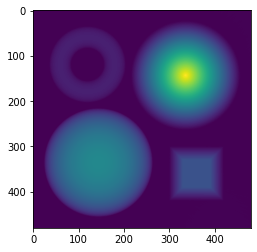

In [3]:
NORMAL_MAP_PATH: str = (
    "https://github.com/YertleTurtleGit/depth-from-normals/blob/main/normal_mapping.png"
)
DEPTH_MAP_PATH: str = "depth_mapping.png"

depth_map_image: np.ndarray = estimate_depth_map(
    NORMAL_MAP_PATH,
    normal_map_is_open_gl=True,
    target_iteration_count=100,
    max_thread_count=2,
)

cv.imwrite(DEPTH_MAP_PATH, depth_map_image)
plt.imshow(depth_map_image)
